## Data preprocessing (scRNA-seq)

In this notebook, I follow the scRNA-seq preprocessing procedure described in **scDCT**.

> For scRNA-seq data, we first perform total count normalization to correct for differences in library size, adjusting each cell’s gene expression values to a common total count, thereby enabling unbiased comparison across cells. A log-transformation is then applied to reduce the dynamic range of expression values and mitigate the influence of extreme outliers while preserving relative expression relationships. To capture key biological signals, we select the top 3000 highly variable genes, resulting in a processed expression matrix  $X_r \in \mathbb{R}^{C \times G}$ , where $C$ is the number of cells and $G$ is the number of selected genes.

**Reference:** [scDCT: a conditional diffusion-based deep learning model for high-fidelity single-cell cross-modality translation](https://academic.oup.com/bib/article/26/4/bbaf400/8223492)


_______________________________________________________________________________________________________________________________________

## 1- Load scRNA-seq (RNA) dataset


This section loads the scRNA-seq dataset stored as an AnnData `.h5ad` file.

**Inputs**
- `data_dir`: directory path containing the file  
- `file_name`: `.h5ad` filename

After loading, we verify the object and print basic summary statistics (cells, genes, metadata fields).


In [25]:
import os
import scanpy as sc

def load_rna_h5ad(data_dir: str, file_name: str):
    """
    Load an scRNA-seq AnnData object from an .h5ad file.

    Parameters
    ----------
    data_dir : str
        Directory path containing the .h5ad file.
    file_name : str
        Name of the .h5ad file.

    Returns
    -------
    adata : anndata.AnnData
        Loaded AnnData object.
    """
    data_dir = os.path.expanduser(data_dir)
    file_path = os.path.join(data_dir, file_name)

    if not os.path.exists(file_path):
        raise FileNotFoundError(
            f"File not found:\n{file_path}\n\n"
            "Check that `data_dir` and `file_name` are correct and that you have read permissions."
        )

    adata = sc.read_h5ad(file_path)

    # Quick summary
    print("Loaded AnnData object:")
    print(adata)
    print("\nShape (cells x genes):", adata.shape)

    return adata


# ---- Example usage ----
data_dir = "/home/khodadadi/pbmc_preprocess/"
file_name = "10x-Multiome-Pbmc10k-RNA.h5ad"

adata_rna = load_rna_h5ad(data_dir, file_name)
adata_rna.layers["counts"] = adata_rna.X.copy()


Loaded AnnData object:
AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

Shape (cells x genes): (9631, 29095)


________________________________________________________________________________________________________________
## 2- Total-count normalization (library-size normalization)

Each cell can have a different sequencing depth (library size). We scale each cell so that the **sum of counts across genes** equals a fixed target (commonly **10,000**). This makes expression values more comparable across cells.

Mathematically, for each cell $c$ with total count $s_c = \sum_g x_{cg}$, we rescale:

$$x'_{cg} = x_{cg}\cdot\frac{\text{target\_sum}}{s_c}$$


**Reference:** [A comprehensive evaluation of normalization methods for Illumina high-throughput RNA sequencing data analysis](https://academic.oup.com/bib/article/14/6/671/189645?login=true)

### Simple example

Raw counts (2 cells × 3 genes):


<div align="center">

| Cell   | Gene1 | Gene2 | Gene3 | Total |
|:------:|------:|------:|------:|------:|
| Cell A | 100   | 50    | 50    | 200   |
| Cell B | 200   | 100   | 200   | 500   |

</div>


Choose a target total = **10,000**.

Scaling factor per cell:
- Cell A: \( 10000 / 200 = 50 \)
- Cell B: \( 10000 / 500 = 20 \)

Normalized counts:
- Cell A → \([100, 50, 50] \times 50 = [5000, 2500, 2500]\) (total = 10,000)
- Cell B → \([200, 100, 200] \times 20 = [4000, 2000, 4000]\) (total = 10,000)

In Scanpy, this is implemented with `sc.pp.normalize_total`.


In [26]:
import scanpy as sc
import numpy as np

def total_count_normalize(adata, target_sum: float = 1e4, copy: bool = True):
    """
    Perform total-count normalization (library-size normalization) on an AnnData object.

    Parameters
    ----------
    adata : anndata.AnnData
        Input AnnData (scRNA-seq).
    target_sum : float
        Desired total counts per cell after normalization (commonly 1e4).
    copy : bool
        If True, return a new AnnData object; if False, modify in place.

    Returns
    -------
    anndata.AnnData
        Normalized AnnData object.
    """
    ad = adata.copy() if copy else adata

    # Store per-cell totals before normalization (useful for sanity checks)
    ad.obs["total_counts_before"] = np.asarray(ad.X.sum(axis=1)).ravel()

    # Normalize so each cell sums to target_sum
    sc.pp.normalize_total(ad, target_sum=target_sum)

    # Store per-cell totals after normalization (should be ~target_sum)
    ad.obs["total_counts_after"] = np.asarray(ad.X.sum(axis=1)).ravel()

    print(f"Done. target_sum={target_sum}")
    print("First 5 totals before:", ad.obs["total_counts_before"].head().to_list())
    print("First 5 totals after :", ad.obs["total_counts_after"].head().to_list())

    return ad

# ---- Apply to your data ----
adata_rna_norm = total_count_normalize(adata_rna, target_sum=1e4, copy=True)


Done. target_sum=10000.0
First 5 totals before: [3771.0, 6876.0, 5415.0, 2759.0, 3632.0]
First 5 totals after : [10000.0009765625, 10000.0, 10000.0, 9999.9990234375, 9999.9990234375]


____________________________________________________________________________________________________________________________________________
## 3- Log-transformation (base 2)

After normalization, values can still have a large dynamic range. We apply a log transform to reduce the influence of extreme values while roughly preserving relative differences.

We use **log base 2** with a +1 pseudocount:

$$x''_{cg} = \log_2(1 + x'_{cg})$$

In [27]:

# Log-transform with base 2: x -> log2(1 + x)
# Scanpy supports base=2; if your scanpy version doesn't, see fallback below.
try:
    sc.pp.log1p(adata_rna_norm, base=2)
    print("Used sc.pp.log1p(base=2).")
except TypeError:
    # Fallback: ln(1+x) / ln(2)
    adata_rna_norm.X = sc.pp.log1p(adata_rna_norm, copy=True).X / np.log(2)
    print("Fallback used: ln(1+x)/ln(2).")
    
adata_rna_norm_log = adata_rna_norm.copy()
# Quick sanity check (values should now be on a log scale)
print("adata.X stats (approx):",
      "min=", float(adata_rna_norm_log.X.min()),
      "max=", float(adata_rna_norm_log.X.max()))


Used sc.pp.log1p(base=2).
adata.X stats (approx): min= 0.0 max= 11.772461891174316


____________________________________________________________________________________
## 4- Select top 3,000 highly variable genes (HVGs)

Not all genes are informative. Many are nearly constant or dominated by noise. HVG selection keeps genes with unusually high variability across cells, which tends to capture key biological signals.

We select the **top 3,000 HVGs**, then subset the matrix to get:

$$X_r \in \mathbb{R}^{C\times G},\quad G=3000$$

where $C$ is the number of cells and $G$ is the number of selected genes.


In [28]:
# Compute HVGs.
# Recommendation: use Seurat v3 flavor on *raw counts* (stored in layers["counts"]).
sc.pp.highly_variable_genes(
    adata_rna_norm_log,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

print("Number of HVGs marked:", int(adata_rna_norm_log.var["highly_variable"].sum()))

# Subset to HVGs
adata_rna_norm_log_hvg = adata_rna_norm_log[:, adata_rna_norm_log.var["highly_variable"]].copy()

# This is your processed matrix X_r (cells x selected genes)
X_r = adata_rna_norm_log_hvg.X
C, G = adata_rna_norm_log_hvg.n_obs, adata_rna_norm_log_hvg.n_vars
print(f"X_r shape: {X_r.shape}  (C={C}, G={G})")


Number of HVGs marked: 3000
X_r shape: (9631, 3000)  (C=9631, G=3000)


___________________________________________________________________________________________________________________________
## 5- PCA visualization of HVG expression (colored by cell type)

After selecting the top **3,000 highly variable genes (HVGs)**, we visualize global cell-to-cell variation using **Principal Component Analysis (PCA)**.  
PCA projects the high-dimensional expression matrix \(X_r \in \mathbb{R}^{C \times 3000}\) into a low-dimensional space (typically 2D) by finding directions (principal components) that capture the largest variance across cells.

In the plot, **each point represents one cell**, and cells are **colored by cell type** (taken from an annotation column in `adata.obs`, e.g., `cell_type`). Clusters of similarly colored points indicate that cells of the same type share similar expression patterns in the HVG space.


/home/khodadadi/miniforge3/envs/preprocess_env/lib/python3.14/functools.py:982: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


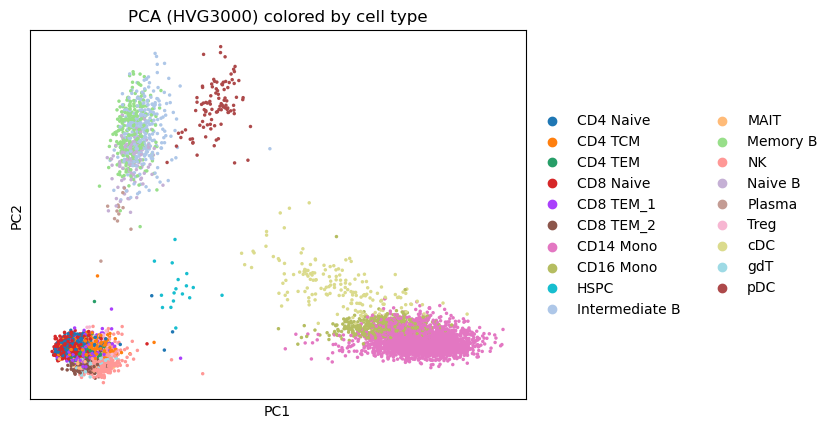

In [29]:
# %% 
# 5) PCA visualization (colored by cell type)

import scanpy as sc

# --- choose the obs column that contains cell-type labels ---
# Change this to the correct column name in your data (e.g., "cell_type", "celltype", "celltype_l2", etc.)
celltype_col = "cell_type"

# Safety check
if celltype_col not in adata_rna_norm_log_hvg.obs.columns:
    raise KeyError(
        f"'{celltype_col}' not found in adata.obs. Available columns:\n"
        f"{adata_rna_norm_log_hvg.obs.columns.tolist()}"
    )

# Optional but common: scale features before PCA
sc.pp.scale(adata_rna_norm_log_hvg, max_value=10)

# Compute PCA (stores coordinates in adata.obsm['X_pca'])
sc.tl.pca(adata_rna_norm_log_hvg, svd_solver="arpack")

# Plot PCA, each cell colored by its cell type
sc.pl.pca(
    adata_rna_norm_log_hvg,
    color=celltype_col,
    size=25,
    title="PCA (HVG3000) colored by cell type"
)


_____________________________________________________________________________________________________________
## 6- Save the final processed data

We save:
- The full preprocessed AnnData object restricted to HVGs (`.h5ad`)
- Optionally, the expression matrix `X_r` as a sparse `.npz` (or dense `.npy` if it is dense)
- Cell and gene identifiers for reproducibility


In [30]:
import os
import numpy as np
import scipy.sparse as sp

def save_preprocessed_rna(
    adata_rna_norm_log_hvg,
    out_dir: str,
    base_name: str = "pbmc_rna_preprocessed_log2_hvg3000",
):
    """
    Save the final preprocessed RNA AnnData + matrix X_r + cell/gene IDs to a given folder.

    Outputs (written into out_dir):
      - {base_name}.h5ad
      - {base_name}_X_r.npz   (if sparse) OR {base_name}_X_r.npy (if dense)
      - {base_name}_cells_barcodes.txt
      - {base_name}_genes_hvg3000.txt

    Parameters
    ----------
    adata_rna_norm_log_hvg : anndata.AnnData
        Final processed AnnData (normalized + log2 + HVG subset).
    out_dir : str
        Directory to save outputs (created if it doesn't exist).
    base_name : str
        Prefix for all output files.

    Returns
    -------
    dict
        Paths to saved files.
    """
    out_dir = os.path.expanduser(out_dir)
    os.makedirs(out_dir, exist_ok=True)

    out_h5ad  = os.path.join(out_dir, f"{base_name}.h5ad")
    out_cells = os.path.join(out_dir, f"{base_name}_cells_barcodes.txt")
    out_genes = os.path.join(out_dir, f"{base_name}_genes_hvg3000.txt")

    # Save AnnData
    adata_rna_norm_log_hvg.write_h5ad(out_h5ad)

    # Save matrix X_r
    X = adata_rna_norm_log_hvg.X
    if sp.issparse(X):
        out_X = os.path.join(out_dir, f"{base_name}_X_r.npz")
        sp.save_npz(out_X, X.tocsr())
    else:
        out_X = os.path.join(out_dir, f"{base_name}_X_r.npy")
        np.save(out_X, X)

    # Save IDs
    np.savetxt(out_cells, adata_rna_norm_log_hvg.obs_names.astype(str), fmt="%s")
    np.savetxt(out_genes, adata_rna_norm_log_hvg.var_names.astype(str), fmt="%s")

    print("Saved:")
    print(" - AnnData:", out_h5ad)
    print(" - X_r    :", out_X)
    print(" - Cells  :", out_cells)
    print(" - Genes  :", out_genes)

    return {"h5ad": out_h5ad, "X_r": out_X, "cells": out_cells, "genes": out_genes}


# ---- Example usage ----
out_dir = "/home/khodadadi/pbmc_preprocess/RNA_PBMC_Preprocessed"
paths = save_preprocessed_rna(adata_rna_norm_log_hvg, out_dir=out_dir)


Saved:
 - AnnData: /home/khodadadi/pbmc_preprocess/RNA_PBMC_Preprocessed/pbmc_rna_preprocessed_log2_hvg3000.h5ad
 - X_r    : /home/khodadadi/pbmc_preprocess/RNA_PBMC_Preprocessed/pbmc_rna_preprocessed_log2_hvg3000_X_r.npy
 - Cells  : /home/khodadadi/pbmc_preprocess/RNA_PBMC_Preprocessed/pbmc_rna_preprocessed_log2_hvg3000_cells_barcodes.txt
 - Genes  : /home/khodadadi/pbmc_preprocess/RNA_PBMC_Preprocessed/pbmc_rna_preprocessed_log2_hvg3000_genes_hvg3000.txt
